#### Base imports

In [2]:
%matplotlib inline
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.optim import Optimizer


import collections
import h5py, sys
import gzip
import os
import math


try:
    import cPickle as pickle
except:
    import pickle

## Some utility functions

In [3]:
def mkdir(paths):
    if not isinstance(paths, (list, tuple)):
        paths = [paths]
    for path in paths:
        if not os.path.isdir(path):
            os.makedirs(path)

from __future__ import print_function
import torch
from torch import nn, optim
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import sys

suffixes = ['B', 'KB', 'MB', 'GB', 'TB', 'PB']
def humansize(nbytes):
    i = 0
    while nbytes >= 1024 and i < len(suffixes)-1:
        nbytes /= 1024.
        i += 1
    f = ('%.2f' % nbytes)
    return '%s%s' % (f, suffixes[i])


def get_num_batches(nb_samples, batch_size, roundup=True):
    if roundup:
        return ((nb_samples + (-nb_samples % batch_size)) / batch_size)  # roundup division
    else:
        return nb_samples / batch_size

def generate_ind_batch(nb_samples, batch_size, random=True, roundup=True):
    if random:
        ind = np.random.permutation(nb_samples)
    else:
        ind = range(int(nb_samples))
    for i in range(int(get_num_batches(nb_samples, batch_size, roundup))):
        yield ind[i * batch_size: (i + 1) * batch_size]

def to_variable(var=(), cuda=True, volatile=False):
    out = []
    for v in var:
        if isinstance(v, np.ndarray):
            v = torch.from_numpy(v).type(torch.FloatTensor)

        if not v.is_cuda and cuda:
            v = v.cuda()

        if not isinstance(v, Variable):
            v = Variable(v, volatile=volatile)

        out.append(v)
    return out
  
def cprint(color, text, **kwargs):
    if color[0] == '*':
        pre_code = '1;'
        color = color[1:]
    else:
        pre_code = ''
    code = {
        'a': '30',
        'r': '31',
        'g': '32',
        'y': '33',
        'b': '34',
        'p': '35',
        'c': '36',
        'w': '37'
    }
    print("\x1b[%s%sm%s\x1b[0m" % (pre_code, code[color], text), **kwargs)
    sys.stdout.flush()

def shuffle_in_unison_scary(a, b):
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)
    
    
import torch.utils.data as data
from PIL import Image
import numpy as np
import h5py



## Dataloader functions

In [4]:
class Datafeed(data.Dataset):

    def __init__(self, x_train, y_train, transform=None):
        self.x_train = x_train
        self.y_train = y_train
        self.transform = transform

    def __getitem__(self, index):
        img = self.x_train[index]
        if self.transform is not None:
            img = self.transform(img)
        return img, self.y_train[index]

    def __len__(self):
        return len(self.x_train)

class DatafeedImage(data.Dataset):
    def __init__(self, x_train, y_train, transform=None):
        self.x_train = x_train
        self.y_train = y_train
        self.transform = transform

    def __getitem__(self, index):
        img = self.x_train[index]
        img = Image.fromarray(np.uint8(img))
        if self.transform is not None:
            img = self.transform(img)
        return img, self.y_train[index]

    def __len__(self):
        return len(self.x_train)

## Base network wrapper

In [5]:
import torch.nn.functional as F
class BaseNet(object):
    def __init__(self):
        cprint('c', '\nNet:')

    def get_nb_parameters(self):
        return np.sum(p.numel() for p in self.model.parameters())

    def set_mode_train(self, train=True):
        if train:
            self.model.train()
        else:
            self.model.eval()

    def update_lr(self, epoch, gamma=0.99):
        self.epoch += 1
        if self.schedule is not None:
            if len(self.schedule) == 0 or epoch in self.schedule:
                self.lr *= gamma
                print('learning rate: %f  (%d)\n' % self.lr, epoch)
                for param_group in self.optimizer.param_groups:
                    param_group['lr'] = self.lr

    def save(self, filename):
        cprint('c', 'Writting %s\n' % filename)
        torch.save({
            'epoch': self.epoch,
            'lr': self.lr,
            'model': self.model,
            'optimizer': self.optimizer}, filename)

    def load(self, filename):
        cprint('c', 'Reading %s\n' % filename)
        state_dict = torch.load(filename)
        self.epoch = state_dict['epoch']
        self.lr = state_dict['lr']
        self.model = state_dict['model']
        self.optimizer = state_dict['optimizer']
        print('  restoring epoch: %d, lr: %f' % (self.epoch, self.lr))
        return self.epoch

## Our models

In [6]:
class Linear_2L(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Linear_2L, self).__init__()
        
        n_hid = 1200
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        self.fc1 = nn.Linear(input_dim, n_hid)
        self.fc2 = nn.Linear(n_hid, n_hid)
        self.fc3 = nn.Linear(n_hid, output_dim)
        
        # choose your non linearity
        #self.act = nn.Tanh()
        #self.act = nn.Sigmoid()
        self.act = nn.ReLU(inplace=True)
        #self.act = nn.ELU(inplace=True)
        #self.act = nn.SELU(inplace=True)

    def forward(self, x):

        x = x.view(-1, self.input_dim) # view(batch_size, input_dim)
        # -----------------
        x = self.fc1(x)
        # -----------------
        x = self.act(x)
        # -----------------
        x = self.fc2(x)
        # -----------------
        x = self.act(x)
        # -----------------
        y = self.fc3(x)

        return y
    
    
        

In [7]:
# param_groups = list(model.parameters())

# for param in param_groups:
#     print(param.data)

## Custom SGLD optimiser

In [8]:
from torch.optim.optimizer import Optimizer, required
class SGLD(Optimizer):
    """
    SGLD optimiser based on pytorch's SGD. 
    Note that the weight decay is specified in terms of the gaussian prior sigma
    """

    def __init__(self, params, lr=required, norm_sigma=0, addnoise=True):
        
        weight_decay = 1/(norm_sigma**2)
        
        if weight_decay < 0.0:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))
        if lr is not required and lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        
        defaults = dict(lr=lr, weight_decay=weight_decay, addnoise=addnoise)
        
        super(SGLD, self).__init__(params, defaults)

    def step(self):
        """
        Performs a single optimization step.
        """
        loss = None
        
        for group in self.param_groups:

            weight_decay = group['weight_decay']
            
            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                if weight_decay != 0:
                    d_p.add_(weight_decay, p.data)
                    
                if group['addnoise']:
                    
                    langevin_noise = p.data.new(p.data.size()).normal_(mean=0, std=1)/np.sqrt(group['lr'])
                    p.data.add_(-group['lr'],
                                0.5*d_p + langevin_noise)
                else:
                    p.data.add_(-group['lr'], 0.5*d_p)

        return loss

### pSGLD optimiser


In [9]:
class pSGLD(Optimizer):
    """
    RMSprop preconditioned SGLD using pytorch rmsprop implementation.
    """

    def __init__(self, params, lr=required, norm_sigma=0, alpha=0.99, eps=1e-8, centered=False, addnoise=True):
        
        weight_decay = 1/(norm_sigma**2)
        
        if weight_decay < 0.0:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))
        if lr is not required and lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        defaults = dict(lr=lr, weight_decay=weight_decay, alpha=alpha, eps=eps, centered=centered, addnoise=addnoise)
        super(pSGLD, self).__init__(params, defaults)
        
    def __setstate__(self, state):
        super(pSGLD, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('centered', False)

    def step(self):
        """
        Performs a single optimization step.
        """
        loss = None

        for group in self.param_groups:
            
            weight_decay = group['weight_decay']
            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                
                state = self.state[p]
                
                if len(state) == 0:
                    state['step'] = 0
                    state['square_avg'] = torch.zeros_like(p.data)
                    if group['centered']:
                        state['grad_avg'] = torch.zeros_like(p.data)
                        
                square_avg = state['square_avg']
                alpha = group['alpha']
                state['step'] += 1
                
                if weight_decay != 0:
                    d_p.add_(weight_decay, p.data)
                
                # sqavg x alpha + (1-alph) sqavg *(elemwise) sqavg
                square_avg.mul_(alpha).addcmul_(1-alpha, d_p, d_p)
                
                if group['centered']:
                    grad_avg = state['grad_avg']
                    grad_avg.mul_(alpha).add_(1-alpha, d_p)
                    avg = square_avg.cmul(-1, grad_avg, grad_avg).sqrt().add_(group['eps'])
                else:
                    avg = square_avg.sqrt().add_(group['eps'])
                    
#                 print(avg.shape)
                if group['addnoise']:
                    langevin_noise = p.data.new(p.data.size()).normal_(mean=0, std=1)/np.sqrt(group['lr'])
                    p.data.add_(-group['lr'],
                                0.5*d_p.div_(avg) + langevin_noise/torch.sqrt(avg))
                    
                else:
                    p.data.addcdiv_(-group['lr'], 0.5*d_p, avg)


        return loss

## Network wrapper

In [10]:
from __future__ import division
import copy

class Net_langevin(BaseNet):
    eps = 1e-6

    def __init__(self, lr=1e-3, channels_in=3, side_in=28, cuda=True, classes=10, N_train=60000, prior_sig=0):
        super(Net_langevin, self).__init__()
        cprint('y', ' Creating Net!! ')
        self.lr = lr
        self.schedule = None  # [] #[50,200,400,600]
        self.cuda = cuda
        self.channels_in = channels_in
        self.prior_sig = prior_sig
        self.classes = classes
        self.N_train = N_train
        self.side_in=side_in
        self.create_net()
        self.create_opt()
        self.epoch = 0
        
        self.weight_set_samples = []

        self.test=False

    def create_net(self):
        torch.manual_seed(42)
        if self.cuda:
            torch.cuda.manual_seed(42)

        self.model = Linear_2L(input_dim=self.channels_in*self.side_in*self.side_in, output_dim=self.classes)
        if self.cuda:
            self.model.cuda()
#             cudnn.benchmark = True

        print('    Total params: %.2fM' % (self.get_nb_parameters() / 1000000.0))

    def create_opt(self):
#         self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr, betas=(0.9, 0.999), eps=1e-08,
#                                           weight_decay=0)
#         self.optimizer = SGLD(params=self.model.parameters(), lr=self.lr, norm_sigma=self.prior_sig, addnoise=True)
        self.optimizer = pSGLD(params=self.model.parameters(), lr=self.lr, norm_sigma=self.prior_sig, addnoise=True)

    #         self.optimizer = torch.optim.SGD(self.model.parameters(), lr=self.lr, momentum=0.9)
#         self.sched = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=1, gamma=10, last_epoch=-1)

    def fit(self, x, y):
        x, y = to_variable(var=(x, y.long()), cuda=self.cuda)

        self.optimizer.zero_grad()

        out = self.model(x)
        loss = F.cross_entropy(out, y, reduction='mean') # We use mean because we treat as an estimation of whole dataset
        loss = loss * self.N_train 
            
        loss.backward()
        self.optimizer.step()

        # out: (batch_size, out_channels, out_caps_dims)
        pred = out.data.max(dim=1, keepdim=False)[1]  # get the index of the max log-probability
        err = pred.ne(y.data).sum()

        return loss.data*x.shape[0]/self.N_train, err

    def eval(self, x, y, train=False):
        x, y = to_variable(var=(x, y.long()), cuda=self.cuda)

        out = self.model(x)

        loss = F.cross_entropy(out, y, reduction='sum')

        probs = F.softmax(out, dim=1).data.cpu()

        pred = out.data.max(dim=1, keepdim=False)[1]  # get the index of the max log-probability
        err = pred.ne(y.data).sum()

        return loss.data, err, probs
    
    def save_sampled_net(self, max_samples):
        
        if len(self.weight_set_samples) >= max_samples:
            self.weight_set_samples.pop(0)
            
        self.weight_set_samples.append(copy.deepcopy(self.model.state_dict()))
        
        cprint('c', ' saving weight samples %d/%d' % (len(self.weight_set_samples), max_samples) )
        
        return None
        
    def sample_eval(self, x, y, Nsamples=0, logits=True, train=False):
        if Nsamples == 0:
            Nsamples = len(self.weight_set_samples)
            
        x, y = to_variable(var=(x, y.long()), cuda=self.cuda)
        
        out = x.data.new(Nsamples, x.shape[0], self.classes)
        
        # iterate over all saved weight configuration samples
        for idx, weight_dict in enumerate(self.weight_set_samples):
            if idx == Nsamples:
                break
            self.model.load_state_dict(weight_dict)
            out[idx] = self.model(x)
        
        
        if logits:
            mean_out = out.mean(dim=0, keepdim=False)
            loss = F.cross_entropy(mean_out, y, reduction='sum')
            probs = F.softmax(mean_out, dim=1).data.cpu()
            
        else:
            mean_out =  F.softmax(out, dim=2).mean(dim=0, keepdim=False)
            probs = mean_out.data.cpu()
            
            log_mean_probs_out = torch.log(mean_out)
            loss = F.nll_loss(log_mean_probs_out, y, reduction='sum')

        pred = mean_out.data.max(dim=1, keepdim=False)[1]  # get the index of the max log-probability
        err = pred.ne(y.data).sum()

        return loss.data, err, probs
    
    
    def all_sample_eval(self, x, y, Nsamples):
        if Nsamples == 0:
            Nsamples = len(self.weight_set_samples)
            
        x, y = to_variable(var=(x, y.long()), cuda=self.cuda)
        
        out = x.data.new(Nsamples, x.shape[0], self.classes)
        
        # iterate over all saved weight configuration samples
        for idx, weight_dict in enumerate(self.weight_set_samples):
            if idx == Nsamples:
                break
            self.model.load_state_dict(weight_dict)
            out[idx] = self.model(x)
        
        prob_out =  F.softmax(out, dim=2)
        prob_out = prob_out.data

        return prob_out
    
    
    def get_weight_samples(self, Nsamples=0):
        weight_vec = []
        
        if Nsamples == 0 or Nsamples > len(self.weight_set_samples):
            Nsamples = len(self.weight_set_samples)
            
        for idx, state_dict in enumerate(self.weight_set_samples):
            if idx == Nsamples:
                break
                
            for key in state_dict.keys():
                if 'weight' in key:
                    weight_mtx = state_dict[key].cpu()
                    for weight in weight_mtx.view(-1):
                        weight_vec.append(weight)
            
        return np.array(weight_vec)

In [11]:
factor = 1.05
print(0.21525*factor)
print(0.189*factor)

0.2260125
0.19845



Data:

Network:

Net:
 Creating Net!! 
    Total params: 2.40M

Train:
  init cost variables:


/homes/ja666/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  import sys


it 0/200, Jtr_pred = 0.327787, err = 0.091683,    time: 4.461258 seconds

    Jdev = 0.217305, err = 0.062300

best test error
it 1/200, Jtr_pred = 0.195617, err = 0.056317,    time: 4.542889 seconds

    Jdev = 0.171833, err = 0.050500

best test error
it 2/200, Jtr_pred = 0.161282, err = 0.046600,    time: 4.570214 seconds

    Jdev = 0.145802, err = 0.042700

best test error
it 3/200, Jtr_pred = 0.141074, err = 0.041533,    time: 4.522334 seconds

    Jdev = 0.138701, err = 0.042600

best test error
it 4/200, Jtr_pred = 0.126658, err = 0.037650,    time: 4.472240 seconds

    Jdev = 0.137538, err = 0.042400

best test error
it 5/200, Jtr_pred = 0.117213, err = 0.035683,    time: 4.460010 seconds

    Jdev = 0.129083, err = 0.038700

best test error
it 6/200, Jtr_pred = 0.109666, err = 0.033367,    time: 4.409143 seconds

    Jdev = 0.126305, err = 0.038900

it 7/200, Jtr_pred = 0.105924, err = 0.032750,    time: 4.390324 seconds

    Jdev = 0.139002, err = 0.043900

it 8/200, Jtr_pr

    Jdev = 0.158700, err = 0.035200

it 56/200, Jtr_pred = 0.059508, err = 0.020100,    time: 4.666043 seconds

 saving weight samples 21/90
    Jdev = 0.145098, err = 0.034100

best test error
it 57/200, Jtr_pred = 0.056862, err = 0.018733,    time: 4.564637 seconds

    Jdev = 0.148354, err = 0.033800

best test error
it 58/200, Jtr_pred = 0.059630, err = 0.019933,    time: 4.401630 seconds

 saving weight samples 22/90
    Jdev = 0.154365, err = 0.034500

it 59/200, Jtr_pred = 0.054708, err = 0.018300,    time: 3.984603 seconds

    Jdev = 0.159006, err = 0.037900

it 60/200, Jtr_pred = 0.055883, err = 0.018567,    time: 3.813604 seconds

 saving weight samples 23/90
    Jdev = 0.165267, err = 0.038800

it 61/200, Jtr_pred = 0.056568, err = 0.019133,    time: 3.563351 seconds

    Jdev = 0.168801, err = 0.039600

it 62/200, Jtr_pred = 0.058612, err = 0.019450,    time: 3.857494 seconds

 saving weight samples 24/90
    Jdev = 0.171926, err = 0.038000

it 63/200, Jtr_pred = 0.056217,

 saving weight samples 48/90
    Jdev = 0.177414, err = 0.035700

it 111/200, Jtr_pred = 0.054672, err = 0.017417,    time: 3.586672 seconds

    Jdev = 0.199219, err = 0.042100

it 112/200, Jtr_pred = 0.052746, err = 0.016300,    time: 3.572512 seconds

 saving weight samples 49/90
    Jdev = 0.170534, err = 0.033300

it 113/200, Jtr_pred = 0.054636, err = 0.017267,    time: 3.615088 seconds

    Jdev = 0.173609, err = 0.036000

it 114/200, Jtr_pred = 0.051176, err = 0.016450,    time: 3.659357 seconds

 saving weight samples 50/90
    Jdev = 0.184525, err = 0.036700

it 115/200, Jtr_pred = 0.051435, err = 0.016433,    time: 3.981005 seconds

    Jdev = 0.182783, err = 0.035700

it 116/200, Jtr_pred = 0.052500, err = 0.017367,    time: 3.855938 seconds

 saving weight samples 51/90
    Jdev = 0.191872, err = 0.039600

it 117/200, Jtr_pred = 0.053907, err = 0.017517,    time: 3.946807 seconds

    Jdev = 0.180990, err = 0.036100

it 118/200, Jtr_pred = 0.053834, err = 0.017317,    time

    Jdev = 0.206668, err = 0.035700

it 166/200, Jtr_pred = 0.049394, err = 0.015833,    time: 3.932917 seconds

 saving weight samples 76/90
    Jdev = 0.204366, err = 0.036900

it 167/200, Jtr_pred = 0.046792, err = 0.015450,    time: 4.046823 seconds

    Jdev = 0.227277, err = 0.043200

it 168/200, Jtr_pred = 0.053741, err = 0.016400,    time: 3.786335 seconds

 saving weight samples 77/90
    Jdev = 0.225985, err = 0.044300

it 169/200, Jtr_pred = 0.051845, err = 0.015817,    time: 3.585082 seconds

    Jdev = 0.200756, err = 0.035400

it 170/200, Jtr_pred = 0.052295, err = 0.016833,    time: 3.780744 seconds

 saving weight samples 78/90
    Jdev = 0.218139, err = 0.038900

it 171/200, Jtr_pred = 0.052200, err = 0.016583,    time: 3.943008 seconds

    Jdev = 0.219118, err = 0.035900

it 172/200, Jtr_pred = 0.051646, err = 0.015950,    time: 3.866087 seconds

 saving weight samples 79/90
    Jdev = 0.223533, err = 0.037400

it 173/200, Jtr_pred = 0.051809, err = 0.016633,    time

<Figure size 600x400 with 0 Axes>

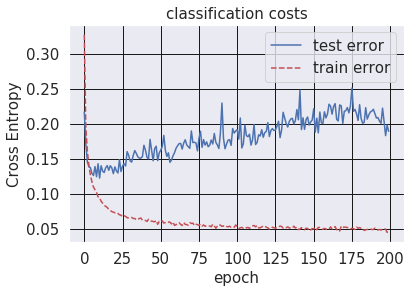

<Figure size 600x400 with 0 Axes>

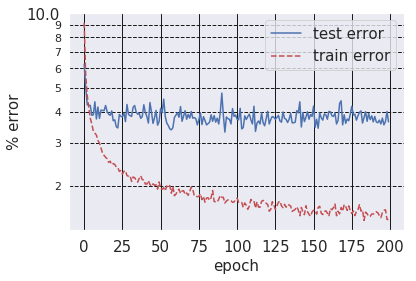

In [11]:
from __future__ import print_function
from __future__ import division
import time
import torch.utils.data
from torchvision import transforms, datasets
import matplotlib


models_dir = 'models_pSGLD_MNIST'
results_dir = 'results_pSGLD_MNIST'

mkdir(models_dir)
mkdir(results_dir)
# ------------------------------------------------------------------------------------------------------
# train config
NTrainPointsMNIST = 60000
batch_size = 128
nb_epochs = 200 # We can do less iterations as this method has faster convergence
log_interval = 1

# ------------------------------------------------------------------------------------------------------
# dataset
cprint('c', '\nData:')


# load data

# data augmentation
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])

use_cuda = torch.cuda.is_available()

trainset = datasets.MNIST(root='../data', train=True, download=True, transform=transform_train)
valset = datasets.MNIST(root='../data', train=False, download=True, transform=transform_test)

if use_cuda:
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=3)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=3)

else:
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=False,
                                              num_workers=3)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=False,
                                            num_workers=3)


## ---------------------------------------------------------------------------------------------------------------------
# net dims
cprint('c', '\nNetwork:')

lr = 1e-4 # 1e-5 for sgld
prior_sig = 0.1
########################################################################################
net = Net_langevin(lr=lr, channels_in=1, side_in=28, cuda=use_cuda, classes=10, N_train=NTrainPointsMNIST, prior_sig=prior_sig)

epoch = 0

## weight saving parameters #######
start_save = 15
save_every = 2 # we can save every 40 as 
N_saves = 90
###################################


## ---------------------------------------------------------------------------------------------------------------------
# train
cprint('c', '\nTrain:')

print('  init cost variables:')
pred_cost_train = np.zeros(nb_epochs)
err_train = np.zeros(nb_epochs)

cost_dev = np.zeros(nb_epochs)
err_dev = np.zeros(nb_epochs)
# best_cost = np.inf
best_err = np.inf


nb_its_dev = 1

tic0 = time.time()
for i in range(epoch, nb_epochs):
    
#     if i in [1]:
#         print('updating lr')
#         net.sched.step()
    
    net.set_mode_train(True)

    tic = time.time()
    nb_samples = 0

    for x, y in trainloader:
        cost_pred, err = net.fit(x, y)

        err_train[i] += err
        pred_cost_train[i] += cost_pred
        nb_samples += len(x)

    pred_cost_train[i] /= nb_samples
    err_train[i] /= nb_samples

    toc = time.time()
    net.epoch = i
    # ---- print
    print("it %d/%d, Jtr_pred = %f, err = %f, " % (i, nb_epochs, pred_cost_train[i], err_train[i]), end="")
    cprint('r', '   time: %f seconds\n' % (toc - tic))
    
    # ---- save weights
    if i >= start_save and i % save_every == 0:
        net.save_sampled_net(max_samples=N_saves)

    # ---- dev
    if i % nb_its_dev == 0:
        net.set_mode_train(False)
        nb_samples = 0
        for j, (x, y) in enumerate(valloader):

            cost, err, probs = net.eval(x, y)

            cost_dev[i] += cost
            err_dev[i] += err
            nb_samples += len(x)

        cost_dev[i] /= nb_samples
        err_dev[i] /= nb_samples

        cprint('g', '    Jdev = %f, err = %f\n' % (cost_dev[i], err_dev[i]))

        if err_dev[i] < best_err:
            best_err = err_dev[i]
            cprint('b', 'best test error')
#             net.save(models_dir+'/theta_best.dat')

toc0 = time.time()
runtime_per_it = (toc0 - tic0) / float(nb_epochs)
cprint('r', '   average time: %f seconds\n' % runtime_per_it)



## ---------------------------------------------------------------------------------------------------------------------
# results
cprint('c', '\nRESULTS:')
nb_parameters = net.get_nb_parameters()
best_cost_dev = np.min(cost_dev)
best_cost_train = np.min(pred_cost_train)
err_dev_min = err_dev[::nb_its_dev].min()

print('  cost_dev: %f (cost_train %f)' % (best_cost_dev, best_cost_train))
print('  err_dev: %f' % (err_dev_min))
print('  nb_parameters: %d (%s)' % (nb_parameters, humansize(nb_parameters)))
print('  time_per_it: %fs\n' % (runtime_per_it))



## Save results for plots
# np.save('results/test_predictions.npy', test_predictions)
np.save(results_dir + '/cost_train.npy', pred_cost_train)
np.save(results_dir + '/cost_dev.npy', cost_dev)
np.save(results_dir + '/err_train.npy', err_train)
np.save(results_dir + '/err_dev.npy', err_dev)

## ---------------------------------------------------------------------------------------------------------------------
# fig cost vs its

textsize = 15
marker=5

plt.figure(dpi=100)
fig, ax1 = plt.subplots()
ax1.plot(range(0, nb_epochs, nb_its_dev), cost_dev[::nb_its_dev], 'b-')
ax1.plot(pred_cost_train, 'r--')
ax1.set_ylabel('Cross Entropy')
plt.xlabel('epoch')
plt.grid(b=True, which='major', color='k', linestyle='-')
plt.grid(b=True, which='minor', color='k', linestyle='--')
lgd = plt.legend(['test error', 'train error'], markerscale=marker, prop={'size': textsize, 'weight': 'normal'})
ax = plt.gca()
plt.title('classification costs')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(textsize)
    item.set_weight('normal')
plt.savefig(results_dir + '/cost.png', bbox_extra_artists=(lgd,), bbox_inches='tight')



plt.figure(dpi=100)
fig2, ax2 = plt.subplots()
ax2.set_ylabel('% error')
ax2.semilogy(range(0, nb_epochs, nb_its_dev), 100 * err_dev[::nb_its_dev], 'b-')
ax2.semilogy(100 * err_train, 'r--')
plt.xlabel('epoch')
plt.grid(b=True, which='major', color='k', linestyle='-')
plt.grid(b=True, which='minor', color='k', linestyle='--')
ax2.get_yaxis().set_minor_formatter(matplotlib.ticker.ScalarFormatter())
ax2.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
lgd = plt.legend(['test error', 'train error'], markerscale=marker, prop={'size': textsize, 'weight': 'normal'})
ax = plt.gca()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(textsize)
    item.set_weight('normal')
plt.savefig(results_dir + '/err.png',  bbox_extra_artists=(lgd,), box_inches='tight')

 
 
 

<Figure size 600x400 with 0 Axes>

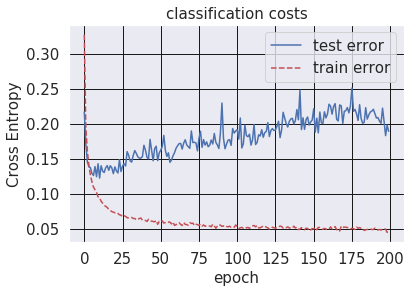

<Figure size 600x400 with 0 Axes>

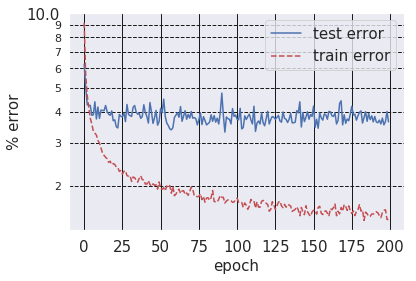

In [14]:

textsize = 15
marker=5

plt.figure(dpi=100)
fig, ax1 = plt.subplots()
ax1.plot(range(0, nb_epochs, nb_its_dev), cost_dev[::nb_its_dev], 'b-')
ax1.plot(pred_cost_train, 'r--')
ax1.set_ylabel('Cross Entropy')
plt.xlabel('epoch')
plt.grid(b=True, which='major', color='k', linestyle='-')
plt.grid(b=True, which='minor', color='k', linestyle='--')
lgd = plt.legend(['test error', 'train error'], markerscale=marker, prop={'size': textsize, 'weight': 'normal'})
ax = plt.gca()
plt.title('classification costs')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(textsize)
    item.set_weight('normal')
plt.savefig(results_dir + '/cost.png', bbox_extra_artists=(lgd,), bbox_inches='tight')



plt.figure(dpi=100)
fig2, ax2 = plt.subplots()
ax2.set_ylabel('% error')
ax2.semilogy(range(0, nb_epochs, nb_its_dev), 100 * err_dev[::nb_its_dev], 'b-')
ax2.semilogy(100 * err_train, 'r--')
plt.xlabel('epoch')
plt.grid(b=True, which='major', color='k', linestyle='-')
plt.grid(b=True, which='minor', color='k', linestyle='--')
ax2.get_yaxis().set_minor_formatter(matplotlib.ticker.ScalarFormatter())
ax2.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
lgd = plt.legend(['test error', 'train error'], markerscale=marker, prop={'size': textsize, 'weight': 'normal'})
ax = plt.gca()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(textsize)
    item.set_weight('normal')
plt.savefig(results_dir + '/err.png',  bbox_extra_artists=(lgd,), bbox_inches='tight')

## save models

In [15]:
# def save_object(obj, filename):
#     with open(filename, 'wb') as output:  # Overwrites any existing file.
#         pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)
        
# save_object(net.weight_set_samples, models_dir+'/state_dicts.pkl')

## Load Models

In [ ]:
from __future__ import print_function
from __future__ import division
import time
import torch.utils.data
from torchvision import transforms, datasets
import matplotlib


models_dir = 'models_pSGLD_MNIST'
results_dir = 'results_pSGLD_MNIST'

mkdir(models_dir)
mkdir(results_dir)
# ------------------------------------------------------------------------------------------------------
# train config
NTrainPointsMNIST = 60000
batch_size = 128
nb_epochs = 200 # We can do less iterations as this method has faster convergence
log_interval = 1

# ------------------------------------------------------------------------------------------------------
# dataset
cprint('c', '\nData:')


# load data

# data augmentation
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])

use_cuda = torch.cuda.is_available()

trainset = datasets.MNIST(root='../data', train=True, download=True, transform=transform_train)
valset = datasets.MNIST(root='../data', train=False, download=True, transform=transform_test)

if use_cuda:
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=3)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=3)

else:
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=False,
                                              num_workers=3)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=False,
                                            num_workers=3)


## ---------------------------------------------------------------------------------------------------------------------
# net dims
cprint('c', '\nNetwork:')

lr = 1e-4 # 1e-5 for sgld
prior_sig = 0.1
########################################################################################
net = Net_langevin(lr=lr, channels_in=1, side_in=28, cuda=use_cuda, classes=10, N_train=NTrainPointsMNIST, prior_sig=prior_sig)

with open(models_dir+'/state_dicts.pkl', 'rb') as input:
    net.weight_set_samples = pickle.load(input)

## inference with sampling on test set

In [17]:
batch_size = 200

if use_cuda:
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4)

else:
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=False,
                                            num_workers=4)
test_cost = 0  # Note that these are per sample
test_err = 0
nb_samples = 0
test_predictions = np.zeros((10000, 10))

Nsamples = 90

net.set_mode_train(False)

for j, (x, y) in enumerate(valloader):
    cost, err, probs = net.sample_eval(x, y, Nsamples, logits=False) # , logits=True

    test_cost += cost
    test_err += err.cpu().numpy()
    test_predictions[nb_samples:nb_samples+len(x), :] = probs.numpy()
    nb_samples += len(x)

# test_cost /= nb_samples
test_err /= nb_samples
cprint('b', '    Loglike = %5.6f, err = %1.6f\n' % (-test_cost, test_err))



    Loglike = -661.259827, err = 0.017600



## rotations, Bayesian [IGNORE THIS FOR NOW]

#### First load data into numpy format

In [18]:
x_dev = []
y_dev = []
for x, y in valloader:
    x_dev.append(x.cpu().numpy())
    y_dev.append(y.cpu().numpy())

x_dev = np.concatenate(x_dev)
y_dev = np.concatenate(y_dev)
print(x_dev.shape)
print(y_dev.shape)

(10000, 1, 28, 28)
(10000,)


(10, 1, 28, 28)


/homes/ja666/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:83: MatplotlibDeprecationWarning: The set_color_cycle function was deprecated in version 1.5. Use `.set_prop_cycle` instead.


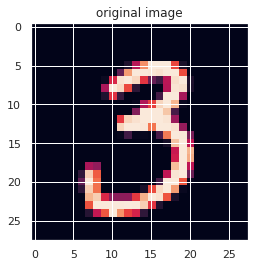

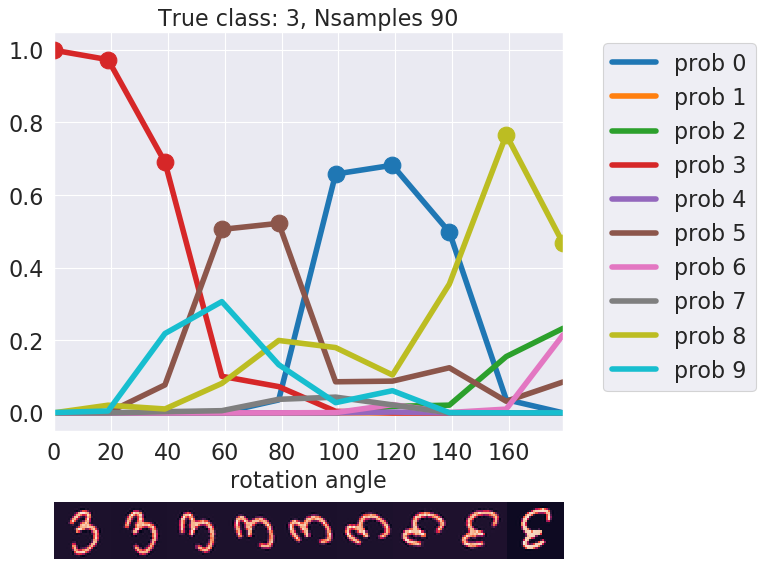

In [19]:
## ROTATIONS marginloss percentile distance
import matplotlib
from torch.autograd import Variable

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()
        
###########################################

import matplotlib.pyplot as plt
import scipy.ndimage as ndim
import matplotlib.colors as mcolors
conv = mcolors.ColorConverter().to_rgb

#############
im_ind = 90
Nsamples = 90
#############

angle = 0
plt.figure()
plt.imshow( ndim.interpolation.rotate(x_dev[im_ind,0,:,:], 0, reshape=False))
plt.title('original image')
# plt.savefig('original_digit.png')


s_rot = 0
end_rot = 179
steps = 10
rotations = (np.linspace(s_rot, end_rot, steps)).astype(int)            
  
ims = []
predictions = []
# percentile_dist_confidence = []
x, y = x_dev[im_ind], y_dev[im_ind]

fig = plt.figure(figsize=(steps, 8), dpi=80)

# DO ROTATIONS ON OUR IMAGE

for i in range(len(rotations)):
    
    angle = rotations[i]
    x_rot = np.expand_dims(ndim.interpolation.rotate(x[0, :, :], angle, reshape=False, cval=-0.42421296), 0)
    
    
    ax = fig.add_subplot(3, (steps-1), 2*(steps-1)+i)
    ax.imshow(x_rot[0,:,:])
    ax.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ims.append(x_rot[:,:,:])
    
ims = np.concatenate(ims)
net.set_mode_train(False)
y = np.ones(ims.shape[0])*y
ims = np.expand_dims(ims, axis=1)
cost, err, probs = net.sample_eval(torch.from_numpy(ims), torch.from_numpy(y), Nsamples=Nsamples, logits=False) # , logits=True

predictions = probs.numpy()
    
    
    
textsize = 20
lw = 5
    
print(ims.shape)
ims = ims[:,0,:,:]
# predictions = np.concatenate(predictions)
#print(percentile_dist_confidence)

c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
     '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']  
                                         

# c = ['#ff0000', '#ffff00', '#00ff00', '#00ffff', '#0000ff',
#      '#ff00ff', '#990000', '#999900', '#009900', '#009999']

ax0 = plt.subplot2grid((3, steps-1), (0, 0), rowspan=2, colspan=steps-1)
#ax0 = fig.add_subplot(2, 1, 1)
plt.gca().set_color_cycle(c)
ax0.plot(rotations, predictions, linewidth=lw)


##########################
# Dots at max

for i in range(predictions.shape[1]):
  
    selections = (predictions[:,i] == predictions.max(axis=1))
    for n in range(len(selections)):
        if selections[n]:
            ax0.plot(rotations[n], predictions[n, i], 'o', c=c[i], markersize=15.0)
##########################  

lgd = ax0.legend(['prob 0', 'prob 1', 'prob 2',
            'prob 3', 'prob 4', 'prob 5',
            'prob 6', 'prob 7', 'prob 8',
            'prob 9'], loc='upper right', prop={'size': textsize, 'weight': 'normal'}, bbox_to_anchor=(1.4,1))
plt.xlabel('rotation angle')
# plt.ylabel('probability')
plt.title('True class: %d, Nsamples %d' % (y[0], Nsamples))
# ax0.axis('tight')
plt.tight_layout()
plt.autoscale(enable=True, axis='x', tight=True)
plt.subplots_adjust(wspace=0, hspace=0)

for item in ([ax0.title, ax0.xaxis.label, ax0.yaxis.label] +
             ax0.get_xticklabels() + ax0.get_yticklabels()):
    item.set_fontsize(textsize)
    item.set_weight('normal')

# plt.savefig('percentile_label_probabilities.png', bbox_extra_artists=(lgd,), bbox_inches='tight')

# files.download('percentile_label_probabilities.png')

In [20]:
## ROTATIONS marginloss percentile distance
import matplotlib
from torch.autograd import Variable

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()
    
        
###########################################

import matplotlib.pyplot as plt
import scipy.ndimage as ndim
import matplotlib.colors as mcolors
conv = mcolors.ColorConverter().to_rgb

Nsamples = 90

s_rot = 0
end_rot = 179
steps = 16
rotations = (np.linspace(s_rot, end_rot, steps)).astype(int)            
  

all_preds = np.zeros((len(x_dev), steps, 10))
all_sample_preds = np.zeros((len(x_dev), Nsamples, steps, 10))

# DO ROTATIONS ON OUR IMAGE
for im_ind in range(len(x_dev)):
    x, y = x_dev[im_ind], y_dev[im_ind]
    print(im_ind)
    
    ims = []
    predictions = []
    for i in range(len(rotations)):

        angle = rotations[i]
        x_rot = np.expand_dims(ndim.interpolation.rotate(x[0, :, :], angle, reshape=False, cval=-0.42421296), 0)
        ims.append(x_rot[:,:,:])
    
    ims = np.concatenate(ims)
    net.set_mode_train(False)
    y = np.ones(ims.shape[0])*y
    ims = np.expand_dims(ims, axis=1)
    
#     cost, err, probs = net.sample_eval(torch.from_numpy(ims), torch.from_numpy(y), Nsamples=Nsamples, logits=False)
    sample_probs = net.all_sample_eval(torch.from_numpy(ims), torch.from_numpy(y), Nsamples=Nsamples)
    probs = sample_probs.mean(dim=0)
    
    all_sample_preds[im_ind, :, :, :] = sample_probs.cpu().numpy()
    predictions = probs.cpu().numpy()
    all_preds[im_ind, :, :] = predictions
   
    
all_preds_entropy = -(all_preds * np.log(all_preds)).sum(axis=2)
mean_angle_entropy = all_preds_entropy.mean(axis=0)
std_angle_entropy = all_preds_entropy.std(axis=0)

correct_preds = np.zeros((len(x_dev), steps))
for i in range(len(x_dev)):
    correct_preds[i,:] = all_preds[i,:,y_dev[i]]
    
correct_mean = correct_preds.mean(axis=0)
correct_std = correct_preds.std(axis=0)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700


5140
5141
5142
5143
5144
5145
5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



9104
9105
9106
9107
9108
9109
9110
9111
9112
9113
9114
9115
9116
9117
9118
9119
9120
9121
9122
9123
9124
9125
9126
9127
9128
9129
9130
9131
9132
9133
9134
9135
9136
9137
9138
9139
9140
9141
9142
9143
9144
9145
9146
9147
9148
9149
9150
9151
9152
9153
9154
9155
9156
9157
9158
9159
9160
9161
9162
9163
9164
9165
9166
9167
9168
9169
9170
9171
9172
9173
9174
9175
9176
9177
9178
9179
9180
9181
9182
9183
9184
9185
9186
9187
9188
9189
9190
9191
9192
9193
9194
9195
9196
9197
9198
9199
9200
9201
9202
9203
9204
9205
9206
9207
9208
9209
9210
9211
9212
9213
9214
9215
9216
9217
9218
9219
9220
9221
9222
9223
9224
9225
9226
9227
9228
9229
9230
9231
9232
9233
9234
9235
9236
9237
9238
9239
9240
9241
9242
9243
9244
9245
9246
9247
9248
9249
9250
9251
9252
9253
9254
9255
9256
9257
9258
9259
9260
9261
9262
9263
9264
9265
9266
9267
9268
9269
9270
9271
9272
9273
9274
9275
9276
9277
9278
9279
9280
9281
9282
9283
9284
9285
9286
9287
9288
9289
9290
9291
9292
9293
9294
9295
9296
9297
9298
9299
9300
9301
9302
9303


In [21]:
np.save(results_dir+'/correct_preds.npy', correct_preds)
np.save(results_dir+'/all_preds.npy', all_preds)
np.save(results_dir+'/all_sample_preds.npy', all_sample_preds) #all_sample_preds

In [22]:
def errorfill(x, y, yerr, color=None, alpha_fill=0.3, ax=None):
    ax = ax if ax is not None else plt.gca()
    if color is None:
        color = ax._get_lines.color_cycle.next()
    if np.isscalar(yerr) or len(yerr) == len(y):
        ymin = y - yerr
        ymax = y + yerr
    elif len(yerr) == 2:
        ymin, ymax = yerr
    ax.plot(x, y, color=color)
    ax.fill_between(x, ymax, ymin, color=color, alpha=alpha_fill)

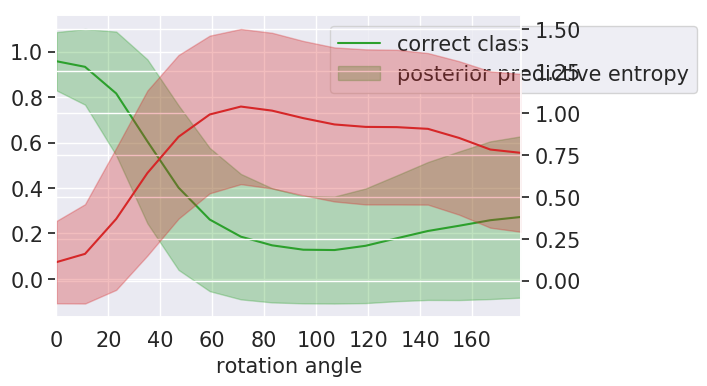

In [23]:
plt.figure(dpi=100)

errorfill(rotations, correct_mean, yerr=correct_std, color=c[2])
          



plt.xlabel('rotation angle')
lgd = plt.legend(['correct class', 'posterior predictive entropy'], loc='upper right',
                 prop={'size': 15, 'weight': 'normal'}, bbox_to_anchor=(1.4,1))
ax = plt.gca()
ax2 = ax.twinx()
errorfill(rotations, mean_angle_entropy, yerr=std_angle_entropy, color=c[3], ax=ax2)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + [ax2.title, ax2.xaxis.label, ax2.yaxis.label] +
            ax.get_xticklabels() + ax.get_yticklabels() + ax2.get_xticklabels() + ax2.get_yticklabels()):
    item.set_fontsize(15)
    item.set_weight('normal')
plt.autoscale(enable=True, axis='x', tight=True)




## Weight histogram


(23928000,)


Text(0.5,1,'Total parameters: 2392800, samples: 10')

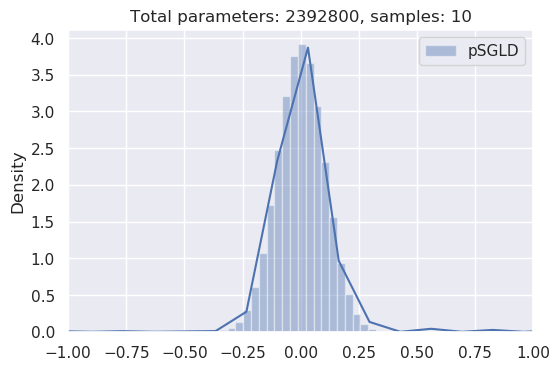

In [19]:
name = 'pSGLD'
Nsamples = 10
# mkdir('weight_samples')
# weight_vector = net.get_weight_samples(Nsamples=Nsamples)
# np.save(results_dir+'/weight_samples_'+name+'.npy', weight_vector)

print(weight_vector.shape)

fig = plt.figure(dpi=100)
ax = fig.add_subplot(111)

sns.distplot(weight_vector, 500, norm_hist=False, label=name, ax=ax)
# ax.hist(weight_vector, bins=70, density=True);
ax.set_xlim((-1, 1))

ax.set_ylabel('Density')
ax.legend()
plt.title('Total parameters: %d, samples: %d' % (len(weight_vector)/Nsamples, Nsamples))